The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.0
!pip install -U mxnet-cu101==1.7.0


# Batch Normalization
:label:`sec_batch_norm`

Training deep neural networks is difficult.
And getting them to converge in a reasonable amount of time can be tricky.
In this section, we describe *batch normalization*, a popular and effective technique
that consistently accelerates the convergence of deep networks :cite:`Ioffe.Szegedy.2015`.
Together with residual blocks---covered later in :numref:`sec_resnet`---batch normalization
has made it possible for practitioners
to routinely train networks with over 100 layers.



## Training Deep Networks

To motivate batch normalization, let us review
a few practical challenges that arise
when training machine learning models and neural networks in particular.

First, choices regarding data preprocessing often make an enormous difference in the final results.
Recall our application of MLPs to predicting house prices (:numref:`sec_kaggle_house`).
Our first step when working with real data
was to standardize our input features
to each have a mean of zero and variance of one.
Intuitively, this standardization plays nicely with our optimizers
because it puts the parameters *a priori* at a similar scale.
   
Second, for a typical MLP or CNN, as we train,
the variables (e.g., affine transformation outputs in MLP)
in intermediate layers 
may take values with widely varying magnitudes:
both along the layers from the input to the output, across units in the same layer,
and over time due to our updates to the model parameters.
The inventors of batch normalization postulated informally
that this drift in the distribution of such variables could hamper the convergence of the network.
Intuitively, we might conjecture that if one
layer has variable values that are 100 times that of another layer,
this might necessitate compensatory adjustments in the learning rates.
   
Third, deeper networks are complex and easily capable of overfitting.
This means that regularization becomes more critical.

Batch normalization is applied to individual layers
(optionally, to all of them) and works as follows:
In each training iteration,
we first normalize the inputs (of batch normalization)
by subtracting their mean and
dividing by their standard deviation,
where both are estimated based on the statistics of the current minibatch.
Next, we apply a scale coefficient and a scale offset.
It is precisely due to this *normalization* based on *batch* statistics
that *batch normalization* derives its name.

Note that if we tried to apply batch normalization with minibatches of size 1,
we would not be able to learn anything.
That is because after subtracting the means,
each hidden unit would take value 0!
As you might guess, since we are devoting a whole section to batch normalization,
with large enough minibatches, the approach proves effective and stable.
One takeaway here is that when applying batch normalization,
the choice of batch size may be
even more significant than without batch normalization.

Formally, denoting by $\mathbf{x} \in \mathcal{B}$ an input to batch normalization ($\mathrm{BN}$)
that is from a minibatch $\mathcal{B}$,
batch normalization transforms $\mathbf{x}$
according to the following expression:

$$\mathrm{BN}(\mathbf{x}) = \boldsymbol{\gamma} \odot \frac{\mathbf{x} - \hat{\boldsymbol{\mu}}_\mathcal{B}}{\hat{\boldsymbol{\sigma}}_\mathcal{B}} + \boldsymbol{\beta}.$$
:eqlabel:`eq_batchnorm`

In :eqref:`eq_batchnorm`,
$\hat{\boldsymbol{\mu}}_\mathcal{B}$ is the  sample mean
and $\hat{\boldsymbol{\sigma}}_\mathcal{B}$ is the sample standard deviation of the minibatch $\mathcal{B}$.
After applying standardization,
the resulting minibatch
has zero mean and unit variance.
Because the choice of unit variance
(vs. some other magic number) is an arbitrary choice,
we commonly include elementwise
*scale parameter* $\boldsymbol{\gamma}$ and *shift parameter* $\boldsymbol{\beta}$
that have the same shape as $\mathbf{x}$.
Note that $\boldsymbol{\gamma}$ and $\boldsymbol{\beta}$ are
 parameters that need to be learned jointly with the other model parameters.

Consequently, the variable magnitudes
for intermediate layers cannot diverge during training
because batch normalization actively centers and rescales them back
to a given mean and size (via $\hat{\boldsymbol{\mu}}_\mathcal{B}$ and ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$).
One piece of practitioner's intuition or wisdom
is that batch normalization seems to allow for more aggressive learning rates.


Formally, 
we calculate $\hat{\boldsymbol{\mu}}_\mathcal{B}$ and ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$ in :eqref:`eq_batchnorm` as follows:

$$\begin{aligned} \hat{\boldsymbol{\mu}}_\mathcal{B} &= \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} \mathbf{x},\\
\hat{\boldsymbol{\sigma}}_\mathcal{B}^2 &= \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} (\mathbf{x} - \hat{\boldsymbol{\mu}}_{\mathcal{B}})^2 + \epsilon.\end{aligned}$$

Note that we add a small constant $\epsilon > 0$
to the variance estimate
to ensure that we never attempt division by zero,
even in cases where the empirical variance estimate might vanish.
The estimates $\hat{\boldsymbol{\mu}}_\mathcal{B}$ and ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$ counteract the scaling issue
by using noisy estimates of mean and variance.
You might think that this noisiness should be a problem.
As it turns out, this is actually beneficial.

This turns out to be a recurring theme in deep learning.
For reasons that are not yet well-characterized theoretically,
various sources of noise in optimization
often lead to faster training and less overfitting:
this variation appears to act as a form of regularization.
In some preliminary research,
:cite:`Teye.Azizpour.Smith.2018` and :cite:`Luo.Wang.Shao.ea.2018`
relate the properties of batch normalization to Bayesian priors and penalties respectively.
In particular, this sheds some light on the puzzle
of why batch normalization works best for moderate minibatches sizes in the $50 \sim 100$ range.

Fixing a trained model, you might think
that we would prefer using the entire dataset
to estimate the mean and variance.
Once training is complete, why would we want
the same image to be classified differently,
depending on the batch in which it happens to reside?
During training, such exact calculation is infeasible
because the intermediate variables
for all data examples
change every time we update our model.
However, once the model is trained,
we can calculate the means and variances
of each layer's variables based on the entire dataset.
Indeed this is standard practice for
models employing batch normalization
and thus batch normalization layers function differently
in *training mode* (normalizing by minibatch statistics)
and in *prediction mode* (normalizing by dataset statistics).

We are now ready to take a look at how batch normalization works in practice.


## Batch Normalization Layers

Batch normalization implementations for fully-connected layers
and convolutional layers are slightly different.
We discuss both cases below.
Recall that one key differences between batch normalization and other layers
is that because batch normalization operates on a full minibatch at a time,
we cannot just ignore the batch dimension
as we did before when introducing other layers.

### Fully-Connected Layers

When applying batch normalization to fully-connected layers,
the original paper inserts batch normalization after the affine transformation
and before the nonlinear activation function (later applications may insert batch normalization right after activation functions) :cite:`Ioffe.Szegedy.2015`.
Denoting the input to the fully-connected layer by $\mathbf{x}$,
the affine transformation
by $\mathbf{W}\mathbf{x} + \mathbf{b}$ (with the weight parameter $\mathbf{W}$ and the bias parameter $\mathbf{b}$),
and the activation function by $\phi$,
we can express the computation of a batch-normalization-enabled,
fully-connected layer output $\mathbf{h}$ as follows:

$$\mathbf{h} = \phi(\mathrm{BN}(\mathbf{W}\mathbf{x} + \mathbf{b}) ).$$

Recall that mean and variance are computed
on the *same* minibatch 
on which the transformation is applied.

### Convolutional Layers

Similarly, with convolutional layers,
we can apply batch normalization after the convolution
and before the nonlinear activation function.
When the convolution has multiple output channels,
we need to carry out batch normalization
for *each* of the outputs of these channels,
and each channel has its own scale and shift parameters,
both of which are scalars.
Assume that our minibatches contain $m$ examples
and that for each channel,
the output of the convolution has height $p$ and width $q$.
For convolutional layers, we carry out each batch normalization
over the $m \cdot p \cdot q$ elements per output channel simultaneously.
Thus, we collect the values over all spatial locations
when computing the mean and variance
and consequently 
apply the same mean and variance
within a given channel
to normalize the value at each spatial location.


### Batch Normalization During Prediction

As we mentioned earlier, batch normalization typically behaves differently
in training mode and prediction mode.
First, the noise in the sample mean and the sample variance
arising from estimating each on minibatches
are no longer desirable once we have trained the model.
Second, we might not have the luxury
of computing per-batch normalization statistics.
For example,
we might need to apply our model to make one prediction at a time.

Typically, after training, we use the entire dataset
to compute stable estimates of the variable statistics
and then fix them at prediction time.
Consequently, batch normalization behaves differently during training and at test time.
Recall that dropout also exhibits this characteristic.

## (**Implementation from Scratch**)

Below, we implement a batch normalization layer with tensors from scratch.


In [1]:
from mxnet import autograd, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use `autograd` to determine whether the current mode is training mode or
    # prediction mode
    if not autograd.is_training():
        # If it is prediction mode, directly use the mean and variance
        # obtained by moving average
        X_hat = (X - moving_mean) / np.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully-connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(axis=0)
            var = ((X - mean)**2).mean(axis=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of `X`, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(axis=(0, 2, 3), keepdims=True)
            var = ((X - mean)**2).mean(axis=(0, 2, 3), keepdims=True)
        # In training mode, the current mean and variance are used for the
        # standardization
        X_hat = (X - mean) / np.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean, moving_var

We can now [**create a proper `BatchNorm` layer.**]
Our layer will maintain proper parameters
for scale `gamma` and shift `beta`,
both of which will be updated in the course of training.
Additionally, our layer will maintain
moving averages of the means and variances
for subsequent use during model prediction.

Putting aside the algorithmic details,
note the design pattern underlying our implementation of the layer.
Typically, we define the mathematics in a separate function, say `batch_norm`.
We then integrate this functionality into a custom layer,
whose code mostly addresses bookkeeping matters,
such as moving data to the right device context,
allocating and initializing any required variables,
keeping track of moving averages (here for mean and variance), and so on.
This pattern enables a clean separation of mathematics from boilerplate code.
Also note that for the sake of convenience
we did not worry about automatically inferring the input shape here,
thus we need to specify the number of features throughout.
Do not worry, the high-level batch normalization APIs in the deep learning framework will care of this for us and we will demonstrate that later.


In [2]:
class BatchNorm(nn.Block):
    # `num_features`: the number of outputs for a fully-connected layer
    # or the number of output channels for a convolutional layer. `num_dims`:
    # 2 for a fully-connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims, **kwargs):
        super().__init__(**kwargs)
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = self.params.get('gamma', shape=shape, init=init.One())
        self.beta = self.params.get('beta', shape=shape, init=init.Zero())
        # The variables that are not model parameters are initialized to 0 and 1
        self.moving_mean = np.zeros(shape)
        self.moving_var = np.ones(shape)

    def forward(self, X):
        # If `X` is not on the main memory, copy `moving_mean` and
        # `moving_var` to the device where `X` is located
        if self.moving_mean.ctx != X.ctx:
            self.moving_mean = self.moving_mean.copyto(X.ctx)
            self.moving_var = self.moving_var.copyto(X.ctx)
        # Save the updated `moving_mean` and `moving_var`
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma.data(), self.beta.data(), self.moving_mean,
            self.moving_var, eps=1e-12, momentum=0.9)
        return Y

## [**Applying Batch Normalization in LeNet**]

To see how to apply `BatchNorm` in context,
below we apply it to a traditional LeNet model (:numref:`sec_lenet`).
Recall that batch normalization is applied
after the convolutional layers or fully-connected layers
but before the corresponding activation functions.


In [3]:
net = nn.Sequential()
net.add(nn.Conv2D(6, kernel_size=5), BatchNorm(6, num_dims=4),
        nn.Activation('sigmoid'), nn.AvgPool2D(pool_size=2, strides=2),
        nn.Conv2D(16, kernel_size=5), BatchNorm(16, num_dims=4),
        nn.Activation('sigmoid'), nn.AvgPool2D(pool_size=2, strides=2),
        nn.Dense(120), BatchNorm(120, num_dims=2), nn.Activation('sigmoid'),
        nn.Dense(84), BatchNorm(84, num_dims=2), nn.Activation('sigmoid'),
        nn.Dense(10))

As before, we will [**train our network on the Fashion-MNIST dataset**].
This code is virtually identical to that when we first trained LeNet (:numref:`sec_lenet`).
The main difference is the larger learning rate.


loss 0.262, train acc 0.903, test acc 0.864
15524.8 examples/sec on gpu(0)


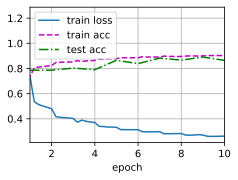

In [4]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

Let us [**have a look at the scale parameter `gamma`
and the shift parameter `beta`**] learned
from the first batch normalization layer.


In [5]:
net[1].gamma.data().reshape(-1,), net[1].beta.data().reshape(-1,)

(array([1.9775715, 2.2259488, 2.8982396, 3.4853864, 4.0083175, 2.4986167], ctx=gpu(0)),
 array([ 2.3617423,  2.5689116, -3.12165  , -1.3387387,  0.8649636,
         0.2328148], ctx=gpu(0)))

## [**Concise Implementation**]

Compared with the `BatchNorm` class,
which we just defined ourselves,
we can use the `BatchNorm` class defined in high-level APIs from the deep learning framework directly.
The code looks virtually identical
to our implementation above.


In [6]:
net = nn.Sequential()
net.add(nn.Conv2D(6, kernel_size=5), nn.BatchNorm(), nn.Activation('sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2), nn.Conv2D(16, kernel_size=5),
        nn.BatchNorm(), nn.Activation('sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2), nn.Dense(120), nn.BatchNorm(),
        nn.Activation('sigmoid'), nn.Dense(84), nn.BatchNorm(),
        nn.Activation('sigmoid'), nn.Dense(10))

Below, we [**use the same hyperparameters to train our model.**]
Note that as usual, the high-level API variant runs much faster
because its code has been compiled to C++ or CUDA
while our custom implementation must be interpreted by Python.


loss 0.284, train acc 0.896, test acc 0.789
34024.5 examples/sec on gpu(0)


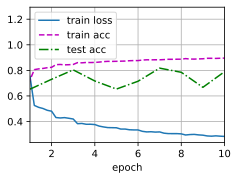

In [7]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## Controversy

Intuitively, batch normalization is thought
to make the optimization landscape smoother.
However, we must be careful to distinguish between
speculative intuitions and true explanations
for the phenomena that we observe when training deep models.
Recall that we do not even know why simpler
deep neural networks (MLPs and conventional CNNs)
generalize well in the first place.
Even with dropout and weight decay,
they remain so flexible that their ability to generalize to unseen data
cannot be explained via conventional learning-theoretic generalization guarantees.

In the original paper proposing batch normalization,
the authors, in addition to introducing a powerful and useful tool,
offered an explanation for why it works:
by reducing *internal covariate shift*.
Presumably by *internal covariate shift* the authors
meant something like the intuition expressed above---the
notion that the distribution of variable values changes
over the course of training.
However, there were two problems with this explanation:
i) This drift is very different from *covariate shift*,
rendering the name a misnomer.
ii) The explanation offers an under-specified intuition
but leaves the question of *why precisely this technique works*
an open question wanting for a rigorous explanation.
Throughout this book, we aim to convey the intuitions that practitioners
use to guide their development of deep neural networks.
However, we believe that it is important
to separate these guiding intuitions
from established scientific fact.
Eventually, when you master this material
and start writing your own research papers
you will want to be clear to delineate
between technical claims and hunches.

Following the success of batch normalization,
its explanation in terms of *internal covariate shift*
has repeatedly surfaced in debates in the technical literature
and broader discourse about how to present machine learning research.
In a memorable speech given while accepting a Test of Time Award
at the 2017 NeurIPS conference,
Ali Rahimi used *internal covariate shift*
as a focal point in an argument likening
the modern practice of deep learning to alchemy.
Subsequently, the example was revisited in detail
in a position paper outlining
troubling trends in machine learning :cite:`Lipton.Steinhardt.2018`.
Other authors
have proposed alternative explanations for the success of batch normalization,
some claiming that batch normalization's success comes despite exhibiting behavior
that is in some ways opposite to those claimed in the original paper :cite:`Santurkar.Tsipras.Ilyas.ea.2018`.

We note that the *internal covariate shift*
is no more worthy of criticism than any of
thousands of similarly vague claims
made every year in the technical machine learning literature.
Likely, its resonance as a focal point of these debates
owes to its broad recognizability to the target audience.
Batch normalization has proven an indispensable method,
applied in nearly all deployed image classifiers,
earning the paper that introduced the technique
tens of thousands of citations.


## Summary

* During model training, batch normalization continuously adjusts the intermediate output of the neural network by utilizing the mean and standard deviation of the minibatch, so that the values of the intermediate output in each layer throughout the neural network are more stable.
* The batch normalization methods for fully-connected layers and convolutional layers are slightly different.
* Like a dropout layer, batch normalization layers have different computation results in training mode and prediction mode.
* Batch normalization has many beneficial side effects, primarily that of regularization. On the other hand, the original motivation of reducing internal covariate shift seems not to be a valid explanation.

## Exercises

1. Can we remove the bias parameter from the fully-connected layer or the convolutional layer before the batch normalization? Why?
1. Compare the learning rates for LeNet with and without batch normalization.
    1. Plot the increase in training and test accuracy.
    1. How large can you make the learning rate?
1. Do we need batch normalization in every layer? Experiment with it?
1. Can you replace dropout by batch normalization? How does the behavior change?
1. Fix the parameters `beta` and `gamma`, and observe and analyze the results.
1. Review the online documentation for `BatchNorm` from the high-level APIs to see the other applications for batch normalization.
1. Research ideas: think of other normalization transforms that you can apply? Can you apply the probability integral transform? How about a full rank covariance estimate?


[Discussions](https://discuss.d2l.ai/t/83)
